# Question - 1

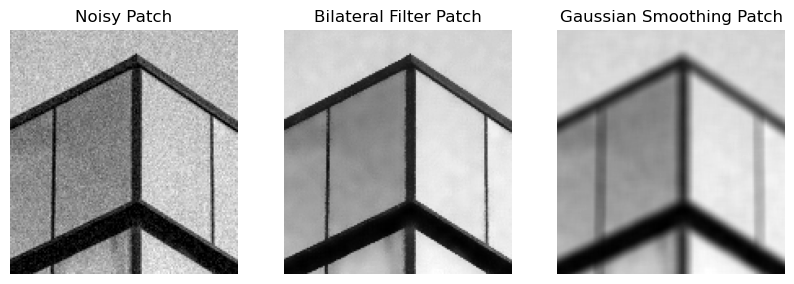

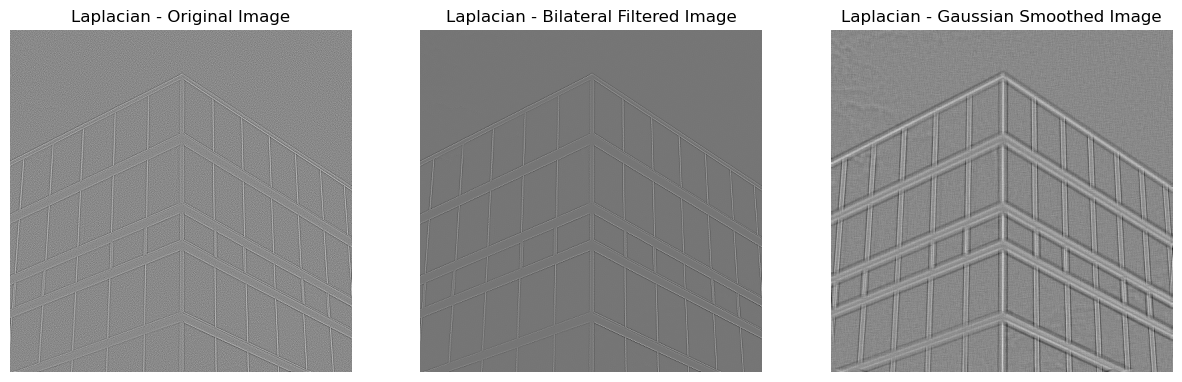

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def gaussian_kernel(size, sigma):
    kernel = np.fromfunction(
        lambda x, y: (1 / (2 * np.pi * sigma ** 2)) * 
                     np.exp(-((x - (size - 1) / 2) ** 2 + (y - (size - 1) / 2) ** 2) / (2 * sigma ** 2)),
        (size, size)
    )
    return kernel / np.sum(kernel)

def gaussian_smoothing(image, kernel_size, sigma):
    kernel = gaussian_kernel(kernel_size, sigma)
    pad_size = kernel_size // 2
    image_padded = np.pad(image, pad_size, mode='reflect')
    smoothed_image = np.zeros_like(image, dtype=np.float32)

    # Convolution operation
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = image_padded[i:i+kernel_size, j:j+kernel_size]
            smoothed_image[i, j] = np.sum(region * kernel)
    
    return np.uint8(np.clip(smoothed_image, 0, 255))

def bilateral_filter_optimized(image, d, sigma_color, sigma_space):
    rows, cols = image.shape
    half_d = d // 2
    image_float = image.astype(np.float32)
    spatial_kernel = gaussian_kernel(d, sigma_space)
    output = np.zeros_like(image_float, dtype=np.float32)

    padded_image = np.pad(image_float, ((half_d, half_d), (half_d, half_d)), mode='reflect')

    for i in range(rows):
        for j in range(cols):
            i_min, i_max = i, i + d
            j_min, j_max = j, j + d

            region = padded_image[i_min:i_max, j_min:j_max]
            intensity_diff = region - image_float[i, j]
            intensity_weight = np.exp(-(intensity_diff**2) / (2 * sigma_color**2))

            weight = spatial_kernel * intensity_weight
            Wp = np.sum(weight)
            filtered_value = np.sum(weight * region)

            output[i, j] = filtered_value / Wp

    return np.uint8(np.clip(output, 0, 255))

# Load the noisy image in grayscale
image = cv2.imread('building_noisy.png', cv2.IMREAD_GRAYSCALE)

# Define a patch of the image (adjust these coordinates based on the image and region of interest)
patch = image[50:200, 180:320]   # Example patch; adjust coordinates as needed

# Parameters for filters
d = 7               # Diameter of the filter window
sigma_color = 40    # Color space standard deviation for bilateral filter
sigma_space = 50    # Spatial standard deviation for bilateral filter
gaussian_sigma = 5  # Standard deviation for Gaussian smoothing
kernel_size = 7     # Kernel size for Gaussian smoothing

# Apply bilateral filter
bilateral_filtered = bilateral_filter_optimized(image, d, sigma_color, sigma_space)

# Apply Gaussian smoothing
gaussian_smoothed = gaussian_smoothing(image, kernel_size, gaussian_sigma)

# Extract the same patch from the filtered images
bilateral_patch = bilateral_filtered[50:200, 180:320] 
gaussian_patch = gaussian_smoothed[50:200, 180:320] 

# Display the patches for comparison
plt.figure(figsize=(10, 5))

# Original noisy patch
plt.subplot(1, 3, 1)
plt.imshow(patch, cmap='gray')
plt.title('Noisy Patch')
plt.axis('off')

# Bilateral filter patch
plt.subplot(1, 3, 2)
plt.imshow(bilateral_patch, cmap='gray')
plt.title('Bilateral Filter Patch')
plt.axis('off')

# Gaussian smoothing patch
plt.subplot(1, 3, 3)
plt.imshow(gaussian_patch, cmap='gray')
plt.title('Gaussian Smoothing Patch')
plt.axis('off')

plt.show()

# Apply Laplacian filter to highlight edges
laplace_original = cv2.Laplacian(image, cv2.CV_64F)
laplace_bilateral = cv2.Laplacian(bilateral_filtered, cv2.CV_64F)
laplace_gaussian = cv2.Laplacian(gaussian_smoothed, cv2.CV_64F)

# Display Laplacian results
plt.figure(figsize=(15, 5))

# Laplacian of Original Image
plt.subplot(1, 3, 1)
plt.imshow(laplace_original, cmap='gray')
plt.title('Laplacian - Original Image')
plt.axis('off')

# Laplacian of Bilateral Filtered Image
plt.subplot(1, 3, 2)
plt.imshow(laplace_bilateral, cmap='gray')
plt.title('Laplacian - Bilateral Filtered Image')
plt.axis('off')

# Laplacian of Gaussian Smoothed Image
plt.subplot(1, 3, 3)
plt.imshow(laplace_gaussian, cmap='gray')
plt.title('Laplacian - Gaussian Smoothed Image')
plt.axis('off')

plt.show()

(-0.5, 511.5, 511.5, -0.5)

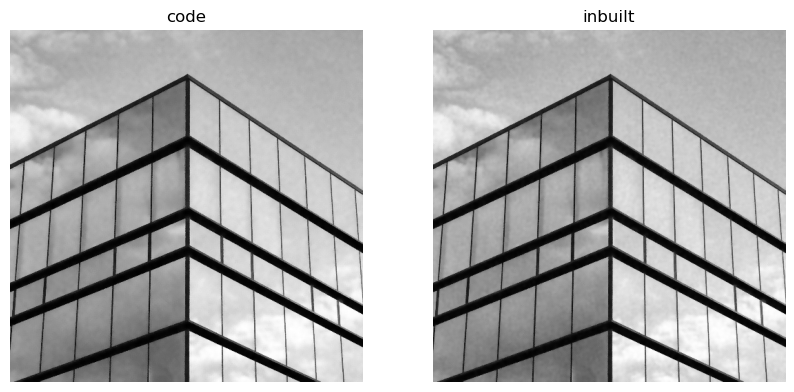

In [2]:
import cv2
bilateral_filtered_2 = cv2.bilateralFilter(image, d, sigma_color, sigma_space)


# Display Laplacian results
plt.figure(figsize=(10, 5))

# Laplacian of Original Image
plt.subplot(1, 2, 1)
plt.imshow(bilateral_filtered, cmap='gray')
plt.title('code')
plt.axis('off')

# Laplacian of Bilateral Filtered Image
plt.subplot(1, 2, 2)
plt.imshow(bilateral_filtered_2, cmap='gray')
plt.title('inbuilt')
plt.axis('off')

# Question-2

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def generate_synthetic_circle_image(img_size=(250, 250), circles_info=[]):
    image = np.zeros(img_size, dtype=np.uint8)
    for (x, y, radius) in circles_info:
        cv2.circle(image, (x, y), radius, 255, -1)
    return image

def hough_transform_circle(edge_img, circle_radius, vote_threshold=200, min_dist=5):
    height, width = edge_img.shape
    hough_accumulator = np.zeros((height, width), dtype=np.int32)
    
    # Fill the Hough accumulator
    for x in range(width):
        for y in range(height):
            if edge_img[y, x]:
                for angle in range(0, 360):
                    theta = np.deg2rad(angle)
                    a = int(x - circle_radius * np.cos(theta))
                    b = int(y - circle_radius * np.sin(theta))
                    if 0 <= a < width and 0 <= b < height:
                        hough_accumulator[b, a] += 1
    
    # Find all points with votes above threshold
    detected_circles = np.argwhere(hough_accumulator >= vote_threshold)
    circles = [(x, y, circle_radius) for y, x in detected_circles]

    # Filter out duplicates based on distance
    filtered_circles = []
    for x, y, r in circles:
        if all(np.linalg.norm(np.array([x, y]) - np.array([fx, fy])) >= min_dist for fx, fy, fr in filtered_circles):
            filtered_circles.append((x, y, r))

    return filtered_circles, hough_accumulator

def display_images(synthetic_img, edge_img, hough_space, detected_circles, title):
    # Create an output image to draw the circles
    output_image = cv2.cvtColor(synthetic_img, cv2.COLOR_GRAY2BGR)
    for (x, y, r) in detected_circles:
        cv2.circle(output_image, (x, y), r, (0, 255, 0), 2)  # Green for circumference
        cv2.circle(output_image, (x, y), 1, (255, 0, 0), 3)  # Blue for center
    
    # Display the images
    plt.figure(figsize=(8,8))
    
    plt.subplot(2, 2, 1)
    plt.imshow(synthetic_img, cmap='gray')
    plt.title('Synthetic Image')
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(edge_img, cmap='gray')
    plt.title('Edge Image')
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(hough_space, cmap='hot')
    plt.title(title)
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title('Detected Circles')
    plt.axis('off')
    
    plt.show()


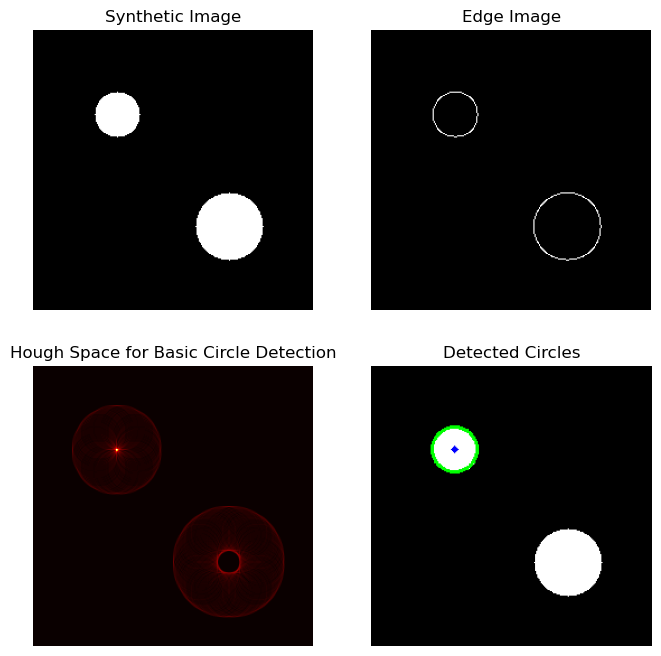

Locations (x, y, radius): [(74, 74, 20)]


In [4]:
# Scenario 1: Basic circle detection
circles_info = [(75, 75, 20), (175, 175, 30)]
synthetic_image = generate_synthetic_circle_image(img_size=(250, 250), circles_info=circles_info)

# Apply edge detection
edges = cv2.Canny(synthetic_image, 100, 200)

# Detect circles using Hough Transform
radius = 20
detected_circles, hough_accumulator = hough_transform_circle(edges, radius, vote_threshold=150)


# Display the images
display_images(synthetic_image, edges, hough_accumulator, detected_circles, 'Hough Space for Basic Circle Detection')

# Print detected circle information
print("Locations (x, y, radius):", detected_circles)


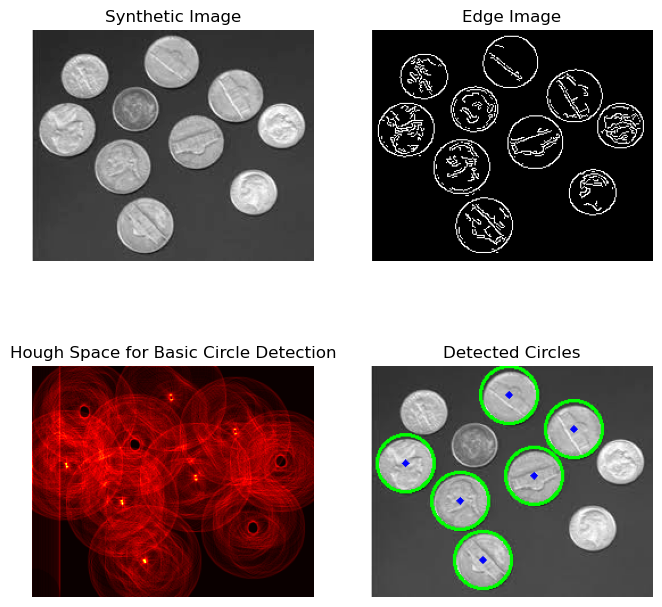

Locations (x, y, radius): [(121, 25, 25), (178, 55, 25), (30, 85, 25), (143, 96, 25), (78, 118, 25), (98, 170, 25)]


In [5]:
coins_img = cv2.imread("coins.png", cv2.IMREAD_GRAYSCALE)
# Apply edge detection
edges = cv2.Canny(coins_img, 100, 200)

# Detect circles using Hough Transform
radius = 25
detected_circles, hough_accumulator = hough_transform_circle(edges, radius, vote_threshold=140)

# Display the images
display_images(coins_img, edges, hough_accumulator,detected_circles, 'Hough Space for Basic Circle Detection')

print("Locations (x, y, radius):", detected_circles)

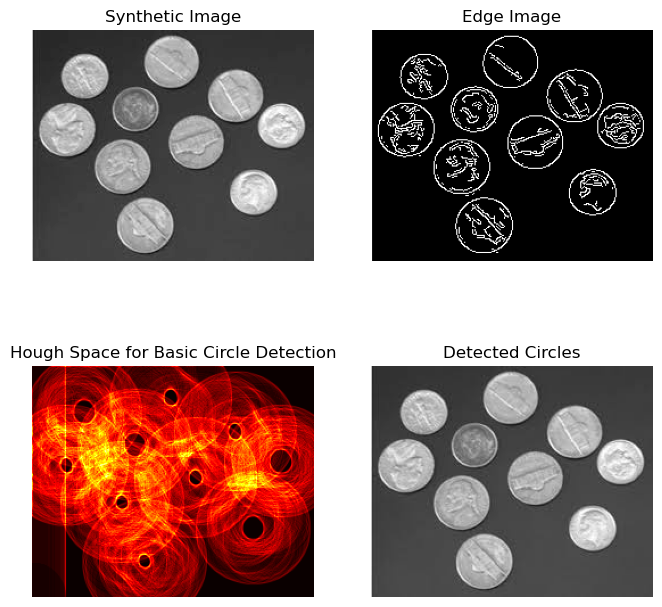

Locations (x, y, radius): []


In [6]:
coins_img = cv2.imread("coins.png", cv2.IMREAD_GRAYSCALE)
# Apply edge detection
edges = cv2.Canny(coins_img, 100, 200)

# Detect circles using Hough Transform
radius = 30
detected_circles, hough_accumulator = hough_transform_circle(edges, radius, vote_threshold=100)

# Display the images
display_images(coins_img, edges, hough_accumulator,detected_circles, 'Hough Space for Basic Circle Detection')

print("Locations (x, y, radius):", detected_circles)

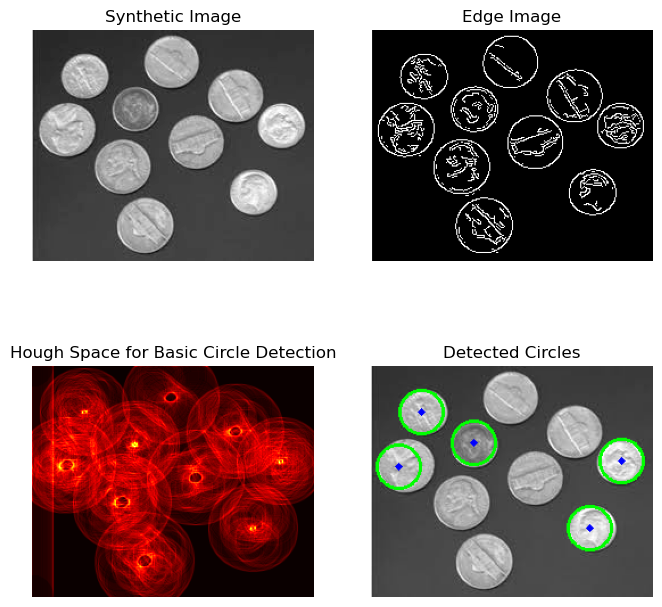

Locations (x, y, radius): [(44, 40, 19), (90, 67, 19), (220, 83, 19), (24, 88, 19), (192, 142, 19)]


In [7]:
coins_img = cv2.imread("coins.png", cv2.IMREAD_GRAYSCALE)
# Apply edge detection
edges = cv2.Canny(coins_img, 100, 200)

# Detect circles using Hough Transform
radius = 19
detected_circles, hough_accumulator = hough_transform_circle(edges, radius, vote_threshold=150)

# Display the images
display_images(coins_img, edges, hough_accumulator,detected_circles, 'Hough Space for Basic Circle Detection')

print("Locations (x, y, radius):", detected_circles)

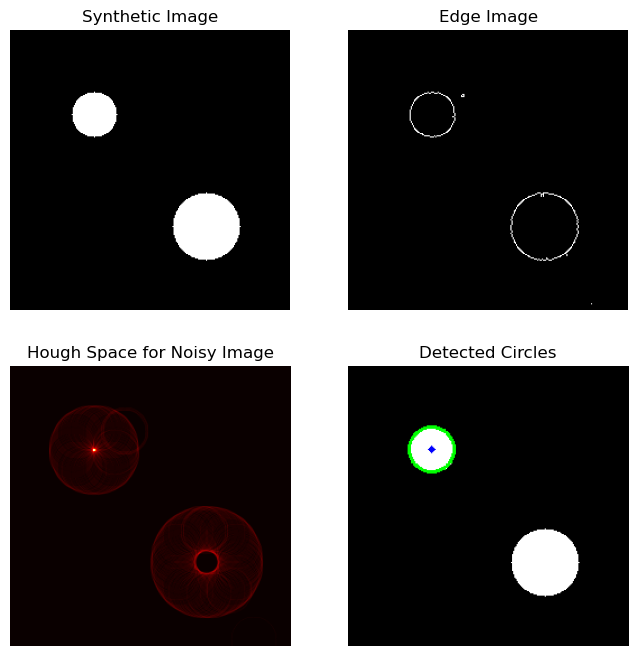

Locations (x, y, radius): [(74, 74, 20)]


In [8]:
# Scenario 2: Presence of noise
circles_info = [(75, 75, 20), (175, 175, 30)]
synthetic_image = generate_synthetic_circle_image(img_size=(250, 250), circles_info=circles_info)

# Add Gaussian noise
gaussian_noise = np.random.normal(0, 15, synthetic_image.shape).astype(np.float32)
noisy_image = cv2.add(synthetic_image.astype(np.float32), gaussian_noise)
noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

# Apply edge detection
edges_noisy = cv2.Canny(noisy_image, 100, 200)

# Detect circles using Hough Transform
radius = 20
detected_circles_noisy, hough_accumulator_noisy = hough_transform_circle(edges_noisy, radius, vote_threshold=100)

# Display the images
display_images(synthetic_image, edges_noisy, hough_accumulator_noisy,detected_circles_noisy, 'Hough Space for Noisy Image')

print("Locations (x, y, radius):", detected_circles_noisy)

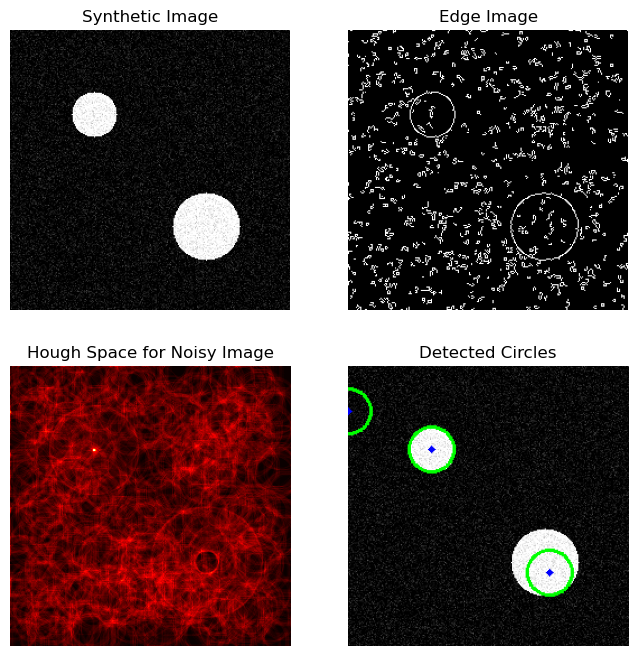

Locations (x, y, radius): [(0, 40, 20), (74, 74, 20), (179, 184, 20)]


In [9]:
# Scenario 2: Presence of noise
circles_info = [(75, 75, 20), (175, 175, 30)]
synthetic_image = generate_synthetic_circle_image(img_size=(250, 250), circles_info=circles_info)

# Add Gaussian noise
gaussian_noise = np.random.normal(0, 25, synthetic_image.shape).astype(np.float32)
noisy_image = cv2.add(synthetic_image.astype(np.float32), gaussian_noise)
noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

# Apply edge detection
edges_noisy = cv2.Canny(noisy_image, 100, 200)

# Detect circles using Hough Transform
radius = 20
detected_circles_noisy, hough_accumulator_noisy = hough_transform_circle(edges_noisy, radius, vote_threshold=100)

# Display the images
display_images(noisy_image, edges_noisy, hough_accumulator_noisy,detected_circles_noisy, 'Hough Space for Noisy Image')

print("Locations (x, y, radius):", detected_circles_noisy)

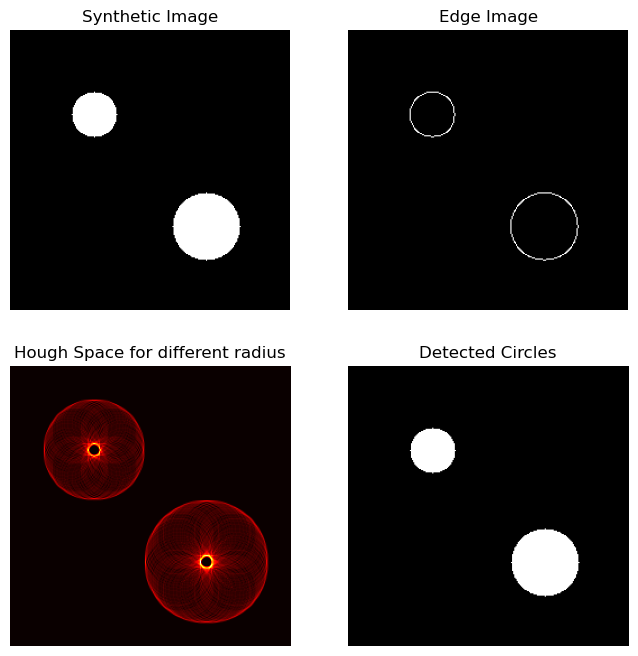

Locations (x, y, radius): []


In [10]:
# Scenario 3: Giving different radius
circles_info = [(75, 75, 20), (175, 175, 30)]
synthetic_image = generate_synthetic_circle_image(img_size=(250, 250), circles_info=circles_info)

# Apply edge detection
edges = cv2.Canny(synthetic_image, 100, 200)

# Detect circles using Hough Transform
radius = 25
detected_circles, hough_accumulator = hough_transform_circle(edges, radius, vote_threshold=150)

# Display the images
display_images(synthetic_image, edges, hough_accumulator,detected_circles, 'Hough Space for different radius')

print("Locations (x, y, radius):", detected_circles)

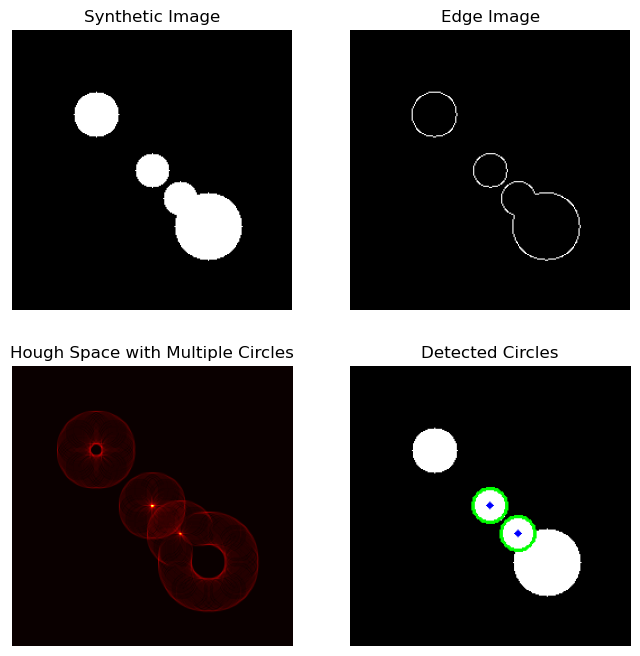

Detected Circles with Multiple Circles: 2
Locations (x, y, radius): [(124, 124, 15), (149, 149, 15)]


In [11]:
# Scenario 4: Increasing number of circles, including partially occluded circles
circles_info = [(75, 75, 20), (175, 175, 30), (125, 125, 15), (150, 150, 15)]
synthetic_image_multiple = generate_synthetic_circle_image(img_size=(250, 250), circles_info=circles_info)

# Apply edge detection
edges_multiple = cv2.Canny(synthetic_image_multiple, 100, 200)

# Detect circles using Hough Transform
radius = 15
detected_circles_multiple, hough_accumulator_multiple = hough_transform_circle(edges_multiple, radius, vote_threshold=100)

# Display the images
display_images(synthetic_image_multiple, edges_multiple, hough_accumulator_multiple,detected_circles_multiple, 'Hough Space with Multiple Circles')

# Output array showing detected circles
print(f"Detected Circles with Multiple Circles: {len(detected_circles_multiple)}")
print("Locations (x, y, radius):", detected_circles_multiple)

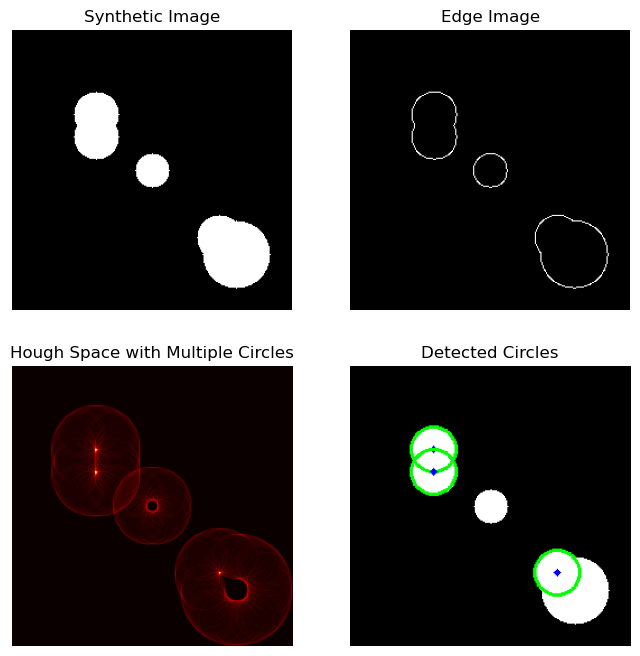

Detected Circles with Multiple Circles: 3
Locations (x, y, radius): [(74, 74, 20), (74, 94, 20), (184, 184, 20)]


In [12]:
# Scenario 4: Increasing number of circles, including partially occluded circles
circles_info = [
    (75, 75, 20),  
    (75, 95, 20),
    (185, 185, 20), 
    (125, 125, 15),  
    (200, 200, 30)   # Circle 6 (more occluded by Circle 2)
]
synthetic_image_multiple = generate_synthetic_circle_image(img_size=(250, 250), circles_info=circles_info)

# Apply edge detection
edges_multiple = cv2.Canny(synthetic_image_multiple, 100, 200)

# Detect circles using Hough Transform
radius = 20
detected_circles_multiple, hough_accumulator_multiple = hough_transform_circle(edges_multiple, radius, vote_threshold=100)

# Display the images
display_images(synthetic_image_multiple, edges_multiple, hough_accumulator_multiple,detected_circles_multiple, 'Hough Space with Multiple Circles')

# Output array showing detected circles
print(f"Detected Circles with Multiple Circles: {len(detected_circles_multiple)}")
print("Locations (x, y, radius):", detected_circles_multiple)

# With different gradient based edge detectors

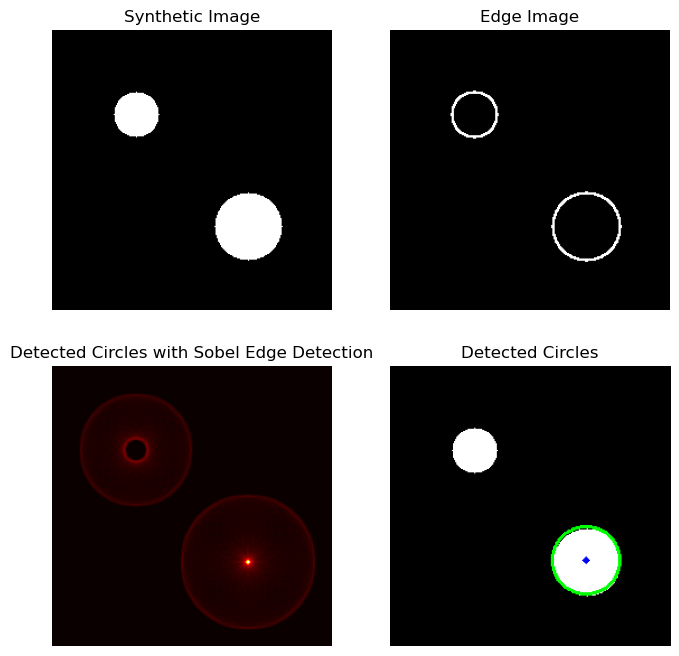

Detected Circles with Sobel: 1
Locations (x, y, radius): [(174, 173, 30)]


In [13]:
circles_info = [(75, 75, 20), (175, 175, 30)]
synthetic_image = generate_synthetic_circle_image(img_size=(250, 250), circles_info=circles_info)

# Apply Sobel edge detection
sobel_x = cv2.Sobel(synthetic_image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(synthetic_image, cv2.CV_64F, 0, 1, ksize=3)
sobel_edges = cv2.magnitude(sobel_x, sobel_y)
sobel_edges = np.uint8(np.clip(sobel_edges, 0, 255))

# Define the radius
radius = 30

# Detect circles using Hough Transform
detected_circles_sobel, hough_accumulator_sobel = hough_transform_circle(sobel_edges, radius, vote_threshold=200)

# Display the images
display_images(synthetic_image, sobel_edges, hough_accumulator_sobel, detected_circles_sobel, 'Detected Circles with Sobel Edge Detection')

# Output array showing detected circles
print(f"Detected Circles with Sobel: {len(detected_circles_sobel)}")
print("Locations (x, y, radius):", detected_circles_sobel)

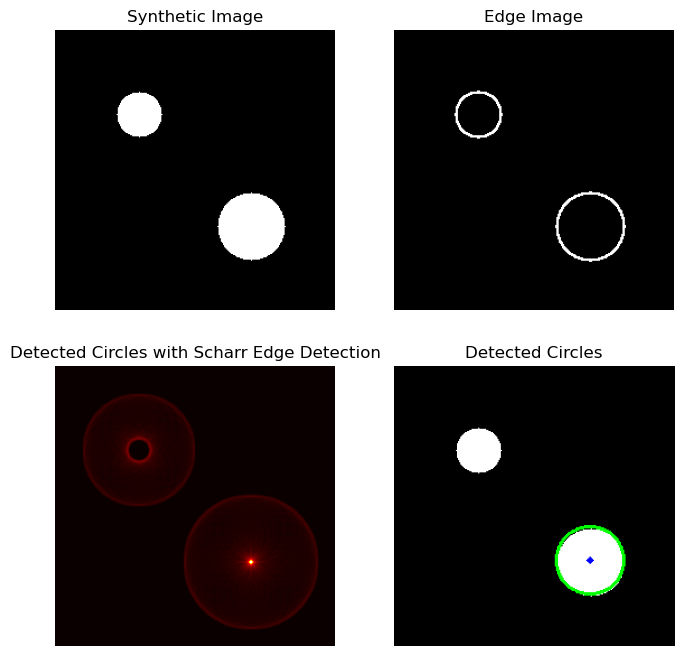

Detected Circles with Scharr: 1
Locations (x, y, radius): [(174, 173, 30)]


In [14]:
# Apply Scharr edge detection
scharr_x = cv2.Scharr(synthetic_image, cv2.CV_64F, 1, 0)
scharr_y = cv2.Scharr(synthetic_image, cv2.CV_64F, 0, 1)
scharr_edges = cv2.magnitude(scharr_x, scharr_y)
scharr_edges = np.uint8(np.clip(scharr_edges, 0, 255))

# Define the radius
radius = 30

# Detect circles using Hough Transform
detected_circles_scharr, hough_accumulator_scharr = hough_transform_circle(scharr_edges, radius, vote_threshold=200)

# Display the images
display_images(synthetic_image, scharr_edges, hough_accumulator_scharr, detected_circles_scharr, 'Detected Circles with Scharr Edge Detection')

# Output array showing detected circles
print(f"Detected Circles with Scharr: {len(detected_circles_scharr)}")
print("Locations (x, y, radius):", detected_circles_scharr)

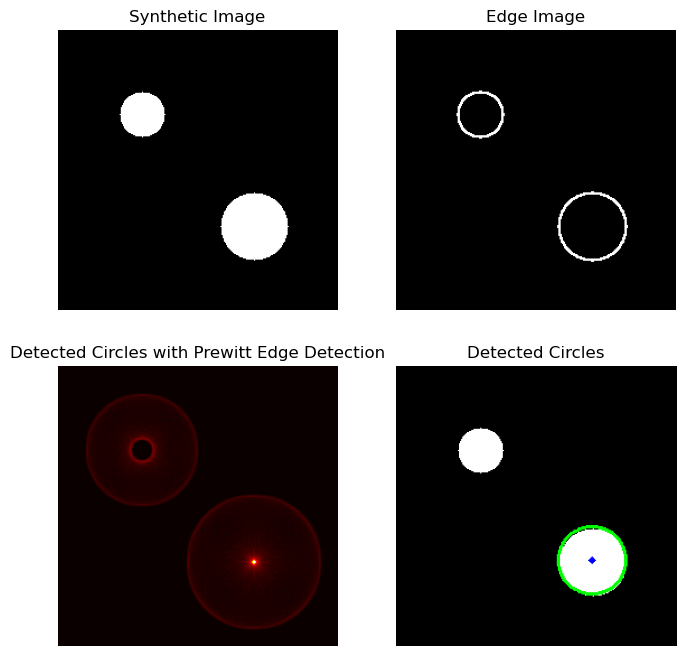

Detected Circles with Prewitt: 1
Locations (x, y, radius): [(174, 173, 30)]


In [15]:
# Apply Prewitt edge detection
prewitt_x = cv2.filter2D(synthetic_image, cv2.CV_64F, np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]))
prewitt_y = cv2.filter2D(synthetic_image, cv2.CV_64F, np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]]))
prewitt_edges = cv2.magnitude(prewitt_x, prewitt_y)
prewitt_edges = np.uint8(np.clip(prewitt_edges, 0, 255))

# Define the radius
radius = 30

# Detect circles using Hough Transform
detected_circles_prewitt, hough_accumulator_prewitt = hough_transform_circle(prewitt_edges, radius, vote_threshold=200)

# Display the images
display_images(synthetic_image, prewitt_edges, hough_accumulator_prewitt, detected_circles_prewitt, 'Detected Circles with Prewitt Edge Detection')

# Output array showing detected circles
print(f"Detected Circles with Prewitt: {len(detected_circles_prewitt)}")
print("Locations (x, y, radius):", detected_circles_prewitt)